In [144]:
# 导入工具库
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [148]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # 将图像统一调整为28x28
    transforms.ToTensor()
])
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='./data', train=False, transform=transform)

In [149]:
class Args:
   def __init__(self):
       self.train_acc = []
       self.test_acc = []
       self.train_loss = []
       self.test_loss = []
       self.epochs = 5
       self.batch_size = 32
       self.num_class = 10
       self.learn_rate = 0.01
       self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

args = Args()

In [150]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # 将图像统一调整为28x28
    transforms.ToTensor()
])

train_dataloader = DataLoader(train_data, batch_size=args.batch_size,shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False)

In [151]:
img, label = next(iter(train_dataloader))
img.shape

torch.Size([32, 1, 28, 28])

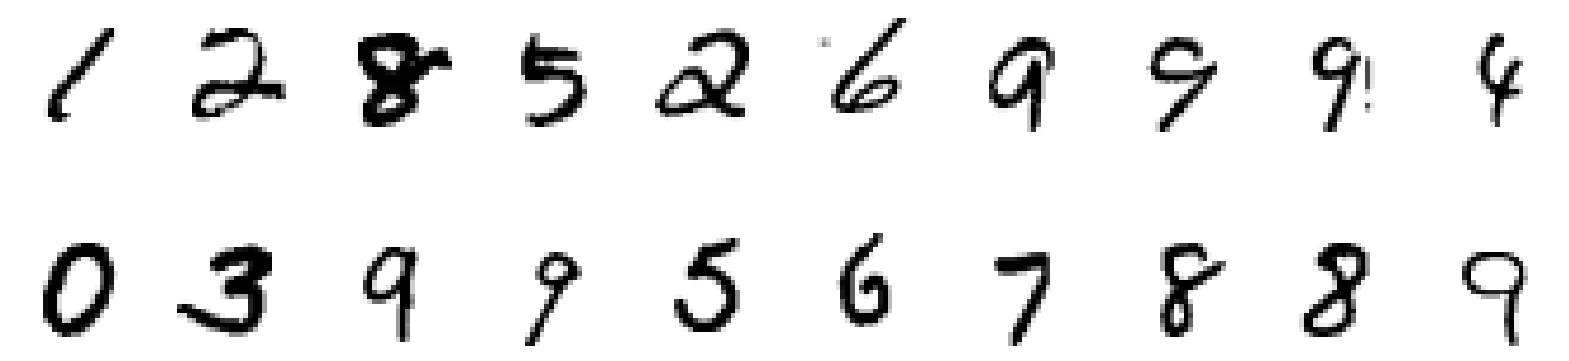

In [152]:
plt.figure(figsize=(20, 5))
for i, img in enumerate(img[:20]):
    nping = np.squeeze(img.numpy())
    plt.subplot(2, 10, i+1)
    plt.imshow(nping, cmap=plt.cm.binary)
    plt.axis('off')
plt.show()

In [153]:
class CNN(nn.Module):
    def __init__(self, class_num):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten(start_dim=0)
        self.linear = nn.Linear(in_features=1600, out_features=64)
        self.output = nn.Linear(in_features=64, out_features=class_num)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.linear(x))
        x = self.output(x)
        
        return x

In [154]:
model = CNN(args.num_class).to(args.device)
print(summary(model, input_size=(1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [10]                      --
├─Conv2d: 1-1                            [32, 26, 26]              320
├─MaxPool2d: 1-2                         [32, 13, 13]              --
├─Conv2d: 1-3                            [64, 11, 11]              18,496
├─MaxPool2d: 1-4                         [64, 5, 5]                --
├─Flatten: 1-5                           [1600]                    --
├─Linear: 1-6                            [64]                      102,464
├─Linear: 1-7                            [10]                      650
Total params: 121,930
Trainable params: 121,930
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 19.85
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.49
Estimated Total Size (MB): 0.73


In [155]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=args.learn_rate)

In [156]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batch = len(dataloader)
    
    train_loss, train_acc = 0, 0
    
    for X, y in dataloader:
        X, y = X.to(args.device), y.to(args.device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()
    
    train_acc /= size
    train_loss /= num_batch
    
    return train_acc, train_loss

In [157]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batch = len(dataloader)
    
    test_loss, test_acc = 0, 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(args.device), labels.to(args.device)
            
            label_pred = model(images)
            loss = loss_fn(label_pred, labels)
            
            test_acc += (label_pred.argmax(1) == labels).type(torch.float).sum().item()
            test_loss += loss.item()
        
        test_acc /= size
        test_loss /= num_batch
        
    return test_acc, test_loss

In [158]:
for epoch in range(args.epochs):
    model.train()
    epoch_train_acc, epoch_train_loss = train(train_dataloader, model, loss_fn, optimizer)
    
    model.eval()
    epoch_test_acc, epoch_test_loss = test(test_dataloader, model, loss_fn)
    
    args.train_acc.append(epoch_train_acc)
    args.test_acc.append(epoch_test_acc)
    args.train_loss.append(epoch_train_loss)
    args.test_loss.append(epoch_test_loss)
    
    template = ("Epoch: {:2d}, Train_acc: {:.1f}%, Train_loss: {:.3f}, Test_acc: {:.1f}%, Test_loss: {:.3f}")
    print(template.format(epoch+1, epoch_train_acc*100, epoch_train_loss, epoch_test_acc*100, epoch_test_loss))
    print("Done")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x51200 and 1600x64)